In [1]:
import os
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import ttest_ind, ttest_rel
# --- Add your entities path ---
sys.path.append(r"E:\Dropbox (Weizmann Institute)\Lab\Code\Python Scripts Jupyter")
from entities_v2 import Experiment  # assumes Experiment is defined there

In [2]:
# --- Constants ---
data_folder = r'Z:\UriMons\Fiber Photometry\GCaMP\adBNST_eEPA_GCaMP8s\Processed_Data\All_pikles'
FRAME_RATE = 30  # Hz
PRE_TIME = 4     # seconds before event
POST_TIME = 4    # seconds after event
BASELINE_REDUCTION = 0.95
BIN_SIZE = 0.333   # seconds
ALPHA = 0.05

IO

In [3]:
def load_experiments(data_folder):
    experiments = []
    for file in os.listdir(data_folder):
        if file.endswith(".pkl"):
            path = os.path.join(data_folder, file)
            with open(path, 'rb') as f:
                exp = pickle.load(f)
                experiments.append(exp)
            print(f"Loaded: {file}")
    print(f"Total .pkl files loaded: {len(experiments)}")
    return experiments

Grouping 

In [4]:
def get_sapap_genotype(geno_str):
    if "Sapap(" in geno_str:
        start = geno_str.find("Sapap(") + len("Sapap(")
        end = geno_str.find(")", start)
        return geno_str[start:end]
    return None

def group_experiments_by_genotype(experiments):
    WT, KO = [], []
    for exp in experiments:
        geno = get_sapap_genotype(exp.Genotype)
        if geno == 'WT':
            WT.append(exp)
        elif geno == 'KO':
            KO.append(exp)
        else:
            print(f"Warning: unknown genotype for {exp.Mouse_id}")
    print(f"WT mice: {len(WT)}, KO mice: {len(KO)}")
    return WT, KO

def _normalize_sex(sex_str):
    if sex_str is None:
        return None
    s = str(sex_str).strip().lower()
    if s in {"f", "female", "♀", "woman", "girl"}:
        return "Female"
    if s in {"m", "male", "♂", "man", "boy"}:
        return "Male"
    return None

def group_experiments_by_sex(experiments):
    females, males = [], []
    for exp in experiments:
        sx = _normalize_sex(getattr(exp, "Sex", None))
        if sx == "Female":
            females.append(exp)
        elif sx == "Male":
            males.append(exp)
        else:
            print(f"Warning: unknown/blank sex for {getattr(exp, 'Mouse_id', 'UNK')}: {getattr(exp, 'Sex', None)}")
    print(f"Female mice: {len(females)}, Male mice: {len(males)}")
    return females, males


Event extraction

In [5]:
def extract_hd_traces(experiments, pre_sec=4, post_sec=4, frame_rate=FRAME_RATE, align_to="onset"):
    aligned = {}
    for exp in experiments:
        aligned[exp.Mouse_id] = []
        ann = getattr(exp, "Headipping_annotations", None) or []
        if len(ann) == 0:
            continue
        t = np.asarray(exp.GCaMP_data.time)
        z = np.asarray(exp.GCaMP_data.z_score)
        if t.ndim != 1 or len(t) != len(z):
            continue
        for (start_frame, end_frame) in ann:
            event_frame = start_frame if align_to == "onset" else end_frame
            event_s = event_frame / float(frame_rate)
            w_start, w_end = event_s - pre_sec, event_s + post_sec
            if w_start < t[0] or w_end > t[-1]:
                continue
            i0 = int(np.searchsorted(t, w_start, side="left"))
            i1 = int(np.searchsorted(t, w_end,   side="right"))
            trace = z[i0:i1]
            time_rel = t[i0:i1] - event_s
            aligned[exp.Mouse_id].append((trace, time_rel))
    return aligned

Alignment & averaging

In [6]:
def build_common_time(pre_sec=4, post_sec=4, frame_rate=FRAME_RATE):
    n = int(round((pre_sec + post_sec) * frame_rate))
    return np.linspace(-pre_sec, post_sec, n, endpoint=False)

def align_hd_traces_to_common(traces_dict, common_t):
    aligned = {}
    for mouse, traces in traces_dict.items():
        aligned[mouse] = []
        for (y, t_rel) in traces:
            idx = np.argsort(t_rel)
            aligned[mouse].append(np.interp(common_t, t_rel[idx], y[idx]))
    return aligned

def center_traces_by_window(traces_dict, fraction: float = 1.0):
    centered = {}
    for mouse, traces in traces_dict.items():
        out = []
        for arr in traces:
            a = np.asarray(arr, dtype=float)
            m = np.nanmean(a)
            if np.isfinite(m):
                a = a - fraction * m
            out.append(a)
        centered[mouse] = out
    return centered

def compute_hd_avg_traces(aligned_data):
    mouse_avg, all_traces = {}, []
    for mouse, traces in aligned_data.items():
        if len(traces) == 0: 
            continue
        stacked = np.vstack(traces).astype(float)
        avg = np.nanmean(stacked, axis=0)
        dd = 1 if stacked.shape[0] > 1 else 0
        sem = np.nanstd(stacked, axis=0, ddof=dd) / np.sqrt(np.sum(~np.isnan(stacked), axis=0).clip(min=1))
        mouse_avg[mouse] = {"avg": avg, "sem": sem}
        all_traces.append(avg)
    if len(all_traces) == 0:
        return mouse_avg, None, None
    all_traces = np.vstack(all_traces).astype(float)
    group_avg = np.nanmean(all_traces, axis=0)
    dd = 1 if all_traces.shape[0] > 1 else 0
    group_sem = np.nanstd(all_traces, axis=0, ddof=dd) / np.sqrt(np.sum(~np.isnan(all_traces), axis=0).clip(min=1))
    return mouse_avg, np.nan_to_num(group_avg), np.nan_to_num(group_sem)

def count_group_events(traces_dict):
    return int(sum(len(v) for v in traces_dict.values()))

# =========================
# PRE/POST scalar extraction (for bar plots)
# =========================

def per_mouse_mean_trace(group_dict):
    """
    group_dict: {mouse_id: [event_trace_on_common_t, ...]}
    Returns: {mouse_id: mean_trace_over_events}
    """
    out = {}
    for mouse, traces in group_dict.items():
        if traces is None or len(traces) == 0:
            continue
        mat = np.vstack(traces).astype(float)
        out[mouse] = np.nanmean(mat, axis=0)
    return out


def binned_mean_over_window(trace, common_t, t_start, t_end, bin_size_s):
    """
    Mean of the trace between [t_start, t_end) using bin_size_s bins.
    Returns one scalar (mean of bin means).
    """
    edges = np.arange(t_start, t_end + 1e-12, bin_size_s)
    if len(edges) < 2:
        raise ValueError("BIN_SIZE is too large for the selected window.")

    bin_means = []
    for i in range(len(edges) - 1):
        a, b = edges[i], edges[i + 1]
        mask = (common_t >= a) & (common_t < b)
        if not np.any(mask):
            continue
        bin_means.append(np.nanmean(trace[mask]))

    if len(bin_means) == 0:
        return np.nan
    return float(np.nanmean(bin_means))


def compute_pre_post_values(group_dict, common_t, pre_time, post_time, bin_size_s):
    """
    Returns:
      pre_vals:  dict mouse_id -> scalar (mean from -pre_time to 0)
      post_vals: dict mouse_id -> scalar (mean from 0 to +post_time)
    """
    mouse_traces = per_mouse_mean_trace(group_dict)

    pre_vals = {}
    post_vals = {}
    for mouse, tr in mouse_traces.items():
        pre_vals[mouse]  = binned_mean_over_window(tr, common_t, -pre_time, 0.0, bin_size_s)
        post_vals[mouse] = binned_mean_over_window(tr, common_t, 0.0, post_time, bin_size_s)

    return pre_vals, post_vals


def mean_sem(x):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if len(x) == 0:
        return np.nan, np.nan
    m = float(np.mean(x))
    se = float(np.std(x, ddof=1) / np.sqrt(len(x))) if len(x) > 1 else np.nan
    return m, se



Statistics 

In [7]:
def compare_groups_over_time(groupA, groupB, common_t, bin_size=BIN_SIZE, frame_rate=FRAME_RATE, alpha=ALPHA):
    def stack_mouse(group):
        mats = []
        for mouse, traces in group.items():
            if len(traces) > 0:
                mats.append(np.nanmean(np.vstack(traces), axis=0))
        return np.vstack(mats) if len(mats) > 0 else None

    A, B = stack_mouse(groupA), stack_mouse(groupB)
    if A is None or B is None: 
        return None, None, None

    n_frames = A.shape[1]
    frames_per_bin = int(round(bin_size * frame_rate))
    n_bins = n_frames // frames_per_bin

    bin_centers, pvals = [], []
    for b in range(n_bins):
        i0, i1 = b * frames_per_bin, (b+1) * frames_per_bin
        if i1 > n_frames: break
        A_bin = np.nanmean(A[:, i0:i1], axis=1)
        B_bin = np.nanmean(B[:, i0:i1], axis=1)
        _, p = ttest_ind(A_bin, B_bin, nan_policy="omit", equal_var=False)
        bin_centers.append(np.mean(common_t[i0:i1]))
        pvals.append(p)

    reject, pvals_corr, _, _ = multipletests(pvals, alpha=alpha, method="fdr_bh")
    return np.array(bin_centers), np.array(pvals_corr), reject.astype(bool)


Plotting 

In [8]:
def plot_traces(common_t, mouse_data, group_avg, group_sem, title, color):
    if group_avg is None or len(group_avg) == 0:
        print(f"⚠️ Skipping plot for {title} — no valid events found.")
        return

    ok = np.isfinite(common_t) & np.isfinite(group_avg) & np.isfinite(group_sem)
    t = common_t[ok]
    mu = group_avg[ok]
    se = np.abs(group_sem[ok])

    plt.figure(figsize=(8, 5))
    for m, d in mouse_data.items():
        if "avg" in d and np.isfinite(d["avg"]).any():
            plt.plot(t, np.interp(t, common_t[:len(d["avg"])], d["avg"]), color='gray', alpha=0.5)

    plt.plot(t, mu, color=color, linewidth=2, label=title)
    plt.fill_between(t, mu - se, mu + se, color=color, alpha=0.3)

    plt.axvline(0, linestyle='--', color='k')
    plt.xlabel("Time (s, aligned to event)")
    plt.ylabel("Z-scored dF/F")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_combined_groups_with_stats(common_t,
                                    groupA, gavg_A, gsem_A, name_A, color_A,
                                    groupB, gavg_B, gsem_B, name_B, color_B,
                                    n_mice_A, n_events_A,
                                    n_mice_B, n_events_B,
                                    bin_size=BIN_SIZE, alpha=ALPHA):
    plt.figure(figsize=(12, 6))

    # Plot group A
    if gavg_A is not None and gsem_A is not None:
        label_A = f"{name_A} (mice={n_mice_A}, events={n_events_A})"
        plt.plot(common_t, gavg_A, color=color_A, linewidth=2, label=label_A)
        plt.fill_between(common_t, gavg_A-gsem_A, gavg_A+gsem_A, color=color_A, alpha=0.3)

    # Plot group B
    if gavg_B is not None and gsem_B is not None:
        label_B = f"{name_B} (mice={n_mice_B}, events={n_events_B})"
        plt.plot(common_t, gavg_B, color=color_B, linewidth=2, label=label_B)
        plt.fill_between(common_t, gavg_B-gsem_B, gavg_B+gsem_B, color=color_B, alpha=0.3)

    plt.axvline(0, linestyle="--", color="k")
    plt.xlabel("Time (s, aligned to event)")
    plt.ylabel("Z-scored dF/F")
    plt.title(f"{name_A} vs {name_B}")
    plt.legend()

    # Run statistical comparison
    bin_centers, pvals_corr, sig_mask = compare_groups_over_time(groupA, groupB, common_t,
                                                                 bin_size=bin_size, alpha=alpha)
    if bin_centers is not None:
        sig_y = min(np.nanmin(gavg_A-gsem_A), np.nanmin(gavg_B-gsem_B)) + 0.4
        for x, sig in zip(bin_centers, sig_mask):
            if sig:
                plt.plot(x, sig_y, marker="*", color="black", markersize=10)

        # Console output
        print(f"\nStatistical test results: {name_A} vs {name_B}")
        for t, p, s in zip(bin_centers, pvals_corr, sig_mask):
            mark = "*" if s else "-"
            print(f"  Bin @ {t:+.2f}s : p={p:.4f} {mark}")

    plt.tight_layout()
    plt.show()

def p_to_stars(p):
    if not np.isfinite(p):
        return "n/a"
    if p < 0.0001:
        return "****"
    if p < 0.001:
        return "***"
    if p < 0.01:
        return "**"
    if p < 0.05:
        return "*"
    return "ns"


def add_sig_bracket(ax, x1, x2, y, text, height=0.03, lw=1.5):
    """
    Draws a significance bracket from x1 to x2 at height y, with label text above.
    """
    ax.plot([x1, x1, x2, x2], [y, y + height, y + height, y], linewidth=lw, color="k")
    ax.text((x1 + x2) / 2, y + height, text, ha="center", va="bottom", color="k")


def plot_pre_post_bars_for_two_groups(common_t,
                                     groupA, name_A, color_A,
                                     groupB, name_B, color_B,
                                     pre_time=PRE_TIME, post_time=POST_TIME,
                                     bin_size=BIN_SIZE,
                                     alpha=ALPHA,
                                     correction_method="fdr_bh"):
    """
    Bar plot with 2 conditions (Pre, Post) and 2 groups (A, B).

    Tests performed (4 total):
      1) Between groups: PRE  (A_pre vs B_pre)
      2) Between groups: POST (A_post vs B_post)
      3) Within A (paired): PRE vs POST
      4) Within B (paired): PRE vs POST

    Applies multiple-comparisons correction across these 4 p-values.
    Prints corrected p-values + significance.
    Draws brackets + stars for significant comparisons.
    """

    # --- Compute per-mouse pre/post scalars ---
    pre_A, post_A = compute_pre_post_values(groupA, common_t, pre_time, post_time, bin_size)
    pre_B, post_B = compute_pre_post_values(groupB, common_t, pre_time, post_time, bin_size)

    # --- Arrays (unpaired) ---
    A_pre_vals  = np.array([v for v in pre_A.values()  if np.isfinite(v)], dtype=float)
    A_post_vals = np.array([v for v in post_A.values() if np.isfinite(v)], dtype=float)
    B_pre_vals  = np.array([v for v in pre_B.values()  if np.isfinite(v)], dtype=float)
    B_post_vals = np.array([v for v in post_B.values() if np.isfinite(v)], dtype=float)

    # --- Paired arrays (within-group) ---
    A_common = sorted(set(pre_A.keys()) & set(post_A.keys()))
    B_common = sorted(set(pre_B.keys()) & set(post_B.keys()))

    A_pre_paired  = np.array([pre_A[m]  for m in A_common if np.isfinite(pre_A[m]) and np.isfinite(post_A[m])], dtype=float)
    A_post_paired = np.array([post_A[m] for m in A_common if np.isfinite(pre_A[m]) and np.isfinite(post_A[m])], dtype=float)

    B_pre_paired  = np.array([pre_B[m]  for m in B_common if np.isfinite(pre_B[m]) and np.isfinite(post_B[m])], dtype=float)
    B_post_paired = np.array([post_B[m] for m in B_common if np.isfinite(pre_B[m]) and np.isfinite(post_B[m])], dtype=float)

    # --- Raw p-values (4 tests) ---
    pvals = []
    test_names = []

    # 1) Between PRE
    p_pre_between = np.nan
    if len(A_pre_vals) >= 2 and len(B_pre_vals) >= 2:
        _, p_pre_between = ttest_ind(A_pre_vals, B_pre_vals, equal_var=False)
    pvals.append(p_pre_between)
    test_names.append(f"{name_A} vs {name_B} (PRE)")

    # 2) Between POST
    p_post_between = np.nan
    if len(A_post_vals) >= 2 and len(B_post_vals) >= 2:
        _, p_post_between = ttest_ind(A_post_vals, B_post_vals, equal_var=False)
    pvals.append(p_post_between)
    test_names.append(f"{name_A} vs {name_B} (POST)")

    # 3) Within A (paired)
    p_within_A = np.nan
    if len(A_pre_paired) >= 2:
        _, p_within_A = ttest_rel(A_pre_paired, A_post_paired)
    pvals.append(p_within_A)
    test_names.append(f"{name_A} (PRE vs POST, paired)")

    # 4) Within B (paired)
    p_within_B = np.nan
    if len(B_pre_paired) >= 2:
        _, p_within_B = ttest_rel(B_pre_paired, B_post_paired)
    pvals.append(p_within_B)
    test_names.append(f"{name_B} (PRE vs POST, paired)")

    pvals = np.array(pvals, dtype=float)

    # --- Multiple comparisons correction across these 4 p-values ---
    valid_mask = np.isfinite(pvals)
    pvals_corr = np.full_like(pvals, np.nan, dtype=float)
    sig_mask = np.zeros_like(pvals, dtype=bool)

    if np.any(valid_mask):
        reject, p_corr, _, _ = multipletests(pvals[valid_mask], alpha=alpha, method=correction_method)
        pvals_corr[valid_mask] = p_corr
        sig_mask[valid_mask] = reject.astype(bool)

    # --- Print output WITH significance flag ---
    print(f"\n=== PRE/POST bars: {name_A} vs {name_B} ({correction_method}, alpha={alpha}) ===")
    print(f"{name_A}: n(pre)={len(A_pre_vals)}, n(post)={len(A_post_vals)}")
    print(f"{name_B}: n(pre)={len(B_pre_vals)}, n(post)={len(B_post_vals)}")

    for name, p_raw, p_c, sig in zip(test_names, pvals, pvals_corr, sig_mask):
        sig_txt = "SIGNIFICANT ✅" if sig else "not sig"
        print(f"{name}: p_raw={p_raw:.4g}  p_corr={p_c:.4g}  -> {sig_txt}")

    # --- Bar plot means + SEM ---
    A_pre_m,  A_pre_se  = mean_sem(A_pre_vals)
    A_post_m, A_post_se = mean_sem(A_post_vals)
    B_pre_m,  B_pre_se  = mean_sem(B_pre_vals)
    B_post_m, B_post_se = mean_sem(B_post_vals)

    labels = ["Pre", "Post"]
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(7, 5))

    # x positions of each bar (for brackets)
    xA_pre  = x[0] - width/2
    xB_pre  = x[0] + width/2
    xA_post = x[1] - width/2
    xB_post = x[1] + width/2

    ax.bar([xA_pre, xA_post],
           [A_pre_m, A_post_m],
           width,
           yerr=[A_pre_se, A_post_se],
           capsize=5,
           label=name_A,
           color=color_A,
           alpha=0.8)

    ax.bar([xB_pre, xB_post],
           [B_pre_m, B_post_m],
           width,
           yerr=[B_pre_se, B_post_se],
           capsize=5,
           label=name_B,
           color=color_B,
           alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Mean Z-score (binned mean)")
    ax.set_title(f"{name_A} vs {name_B}: Pre vs Post")
    ax.legend()
    ax.axhline(0, linestyle="--", linewidth=1, color="k")

    # --- Add brackets for significant comparisons (using corrected p-values) ---
    # Determine a base Y above the tallest bar+sem
    all_tops = [
        A_pre_m + (A_pre_se if np.isfinite(A_pre_se) else 0),
        B_pre_m + (B_pre_se if np.isfinite(B_pre_se) else 0),
        A_post_m + (A_post_se if np.isfinite(A_post_se) else 0),
        B_post_m + (B_post_se if np.isfinite(B_post_se) else 0),
    ]
    y_base = np.nanmax(all_tops)
    if not np.isfinite(y_base):
        y_base = 0.0
    step = 0.03 * (abs(y_base) + 1.0)  # spacing between brackets

    y_cursor = y_base + step

    # Index mapping:
    # 0: between PRE, 1: between POST, 2: within A, 3: within B
    comparisons = [
        (0, xA_pre,  xB_pre,  "between PRE"),
        (1, xA_post, xB_post, "between POST"),
        (2, xA_pre,  xA_post, f"{name_A} pre vs post"),
        (3, xB_pre,  xB_post, f"{name_B} pre vs post"),
    ]

    for idx, x1, x2, _desc in comparisons:
        if sig_mask[idx]:
            stars = p_to_stars(pvals_corr[idx])
            add_sig_bracket(ax, x1, x2, y_cursor, stars)
            y_cursor += step

    plt.tight_layout()
    plt.show()


Main 

Loaded: M329_eEPA_R_adBNST.pkl
Loaded: M338_eEPA_R_adBNST.pkl
Loaded: M344_eEPA_R_adBNST.pkl
Loaded: M352_eEPA_R_adBNST.pkl
Loaded: M354_eEPA_R_adBNST.pkl
Loaded: M365_eEPA_R_adBNST.pkl
Loaded: M406_eEPA_R_adBNST.pkl
Loaded: M407_eEPA_R_adBNST.pkl
Loaded: M416_eEPA_R_adBNST.pkl
Loaded: M420_eEPA_R_adBNST.pkl
Loaded: M501_eEPA_R_adBNST.pkl
Loaded: M508_eEPA_R_adBNST.pkl
Loaded: M511_eEPA_R_adBNST.pkl
Loaded: M546_eEPA_R_adBNST.pkl
Loaded: M561_eEPA_R_adBNST.pkl
Total .pkl files loaded: 15
WT mice: 7, KO mice: 8
Female mice: 9, Male mice: 6

=== WT vs KO PRE/POST (ONSET) ===
WT n (pre)=7, WT n (post)=7
KO n (pre)=8, KO n (post)=8
WT vs KO (PRE):  p = 0.2157
WT vs KO (POST): p = 0.5638
WT PRE vs POST (paired): p = 0.4169  (n=7)
KO PRE vs POST (paired): p = 0.008624  (n=8)


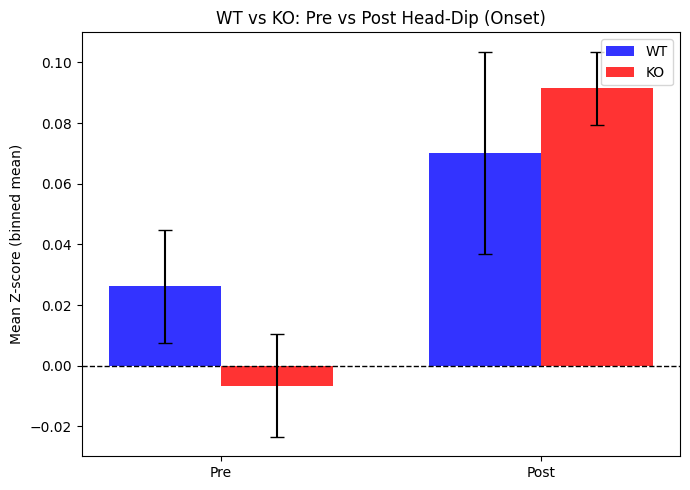

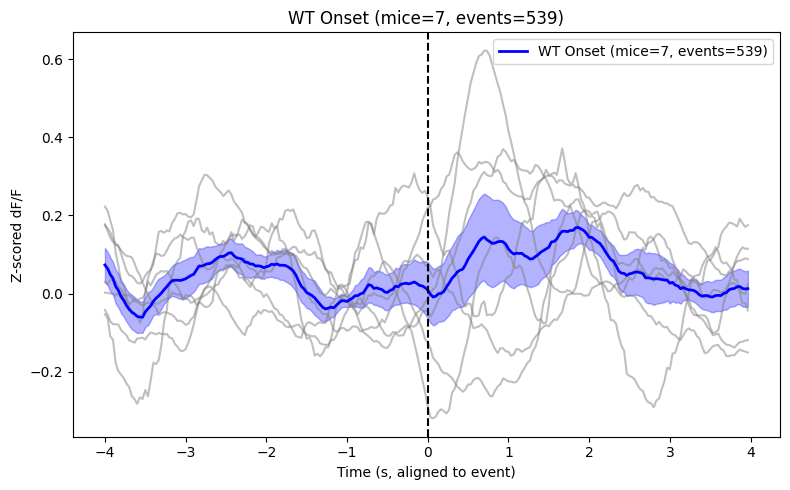

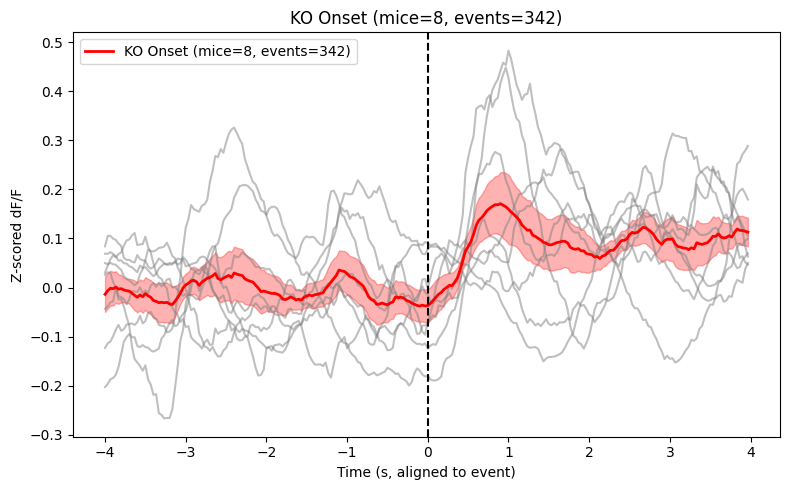

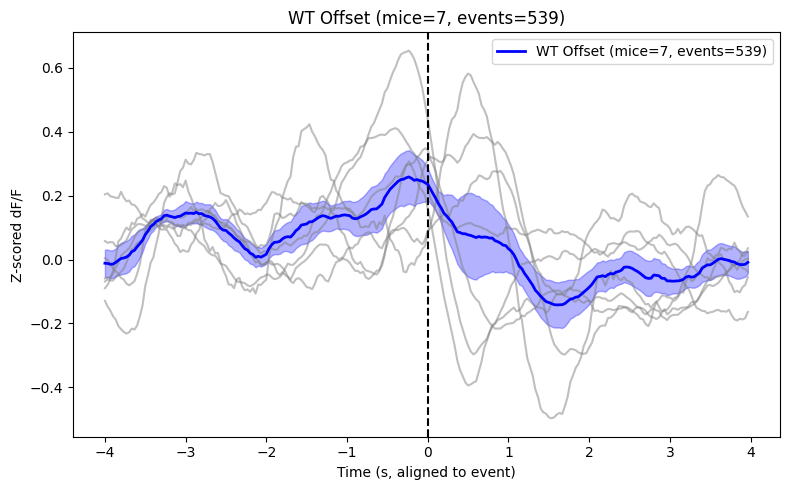

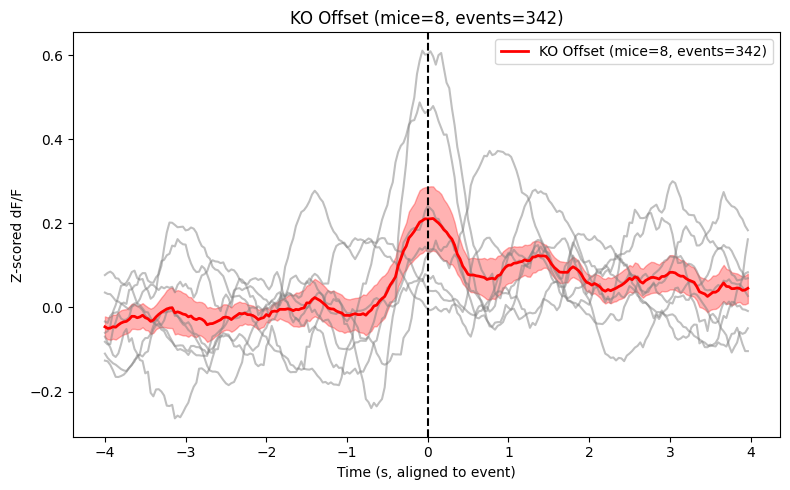

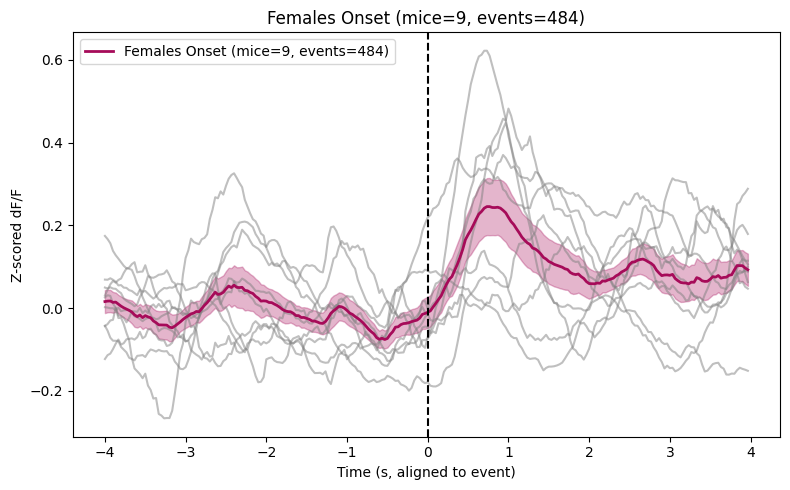

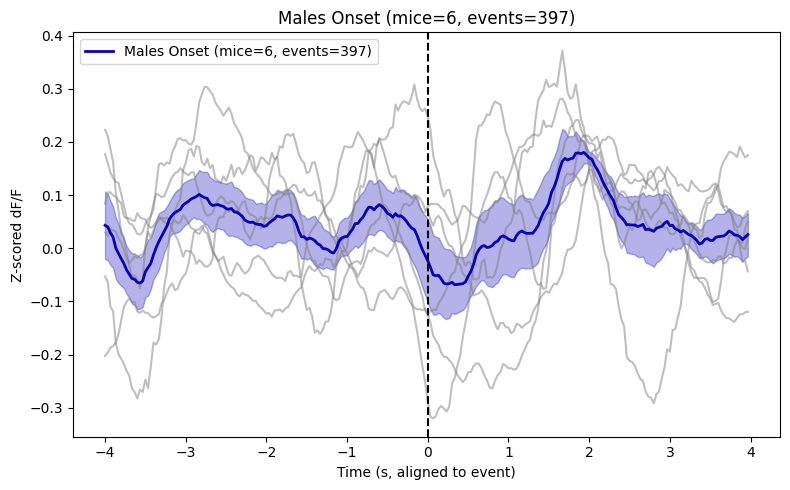

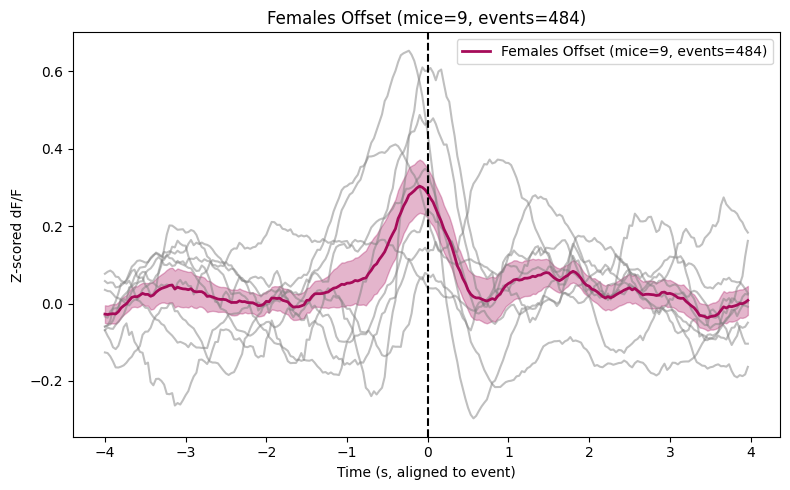

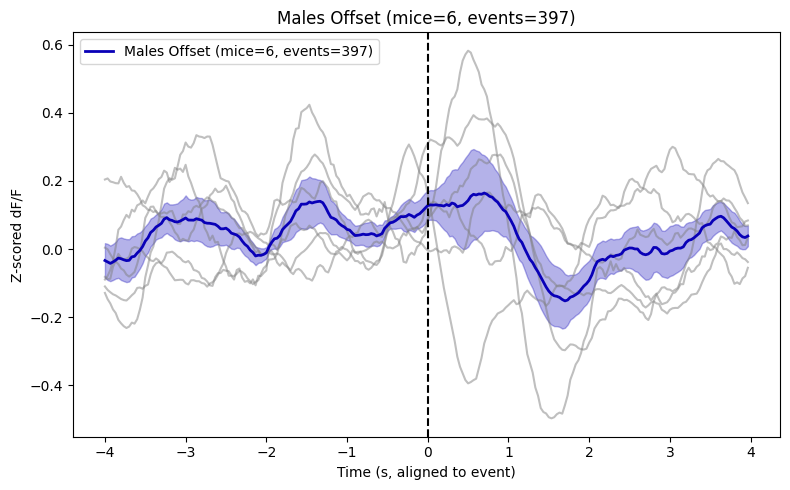


Statistical test results: WT vs KO (Onset)
  Bin @ -3.85s : p=0.8986 -
  Bin @ -3.52s : p=0.8962 -
  Bin @ -3.18s : p=0.7005 -
  Bin @ -2.85s : p=0.7005 -
  Bin @ -2.52s : p=0.7005 -
  Bin @ -2.18s : p=0.7005 -
  Bin @ -1.85s : p=0.7005 -
  Bin @ -1.52s : p=0.7362 -
  Bin @ -1.18s : p=0.7005 -
  Bin @ -0.85s : p=0.9208 -
  Bin @ -0.52s : p=0.7362 -
  Bin @ -0.18s : p=0.7005 -
  Bin @ +0.15s : p=0.9010 -
  Bin @ +0.48s : p=0.9208 -
  Bin @ +0.82s : p=0.9010 -
  Bin @ +1.15s : p=0.8986 -
  Bin @ +1.48s : p=0.8986 -
  Bin @ +1.82s : p=0.7005 -
  Bin @ +2.15s : p=0.7005 -
  Bin @ +2.48s : p=0.7005 -
  Bin @ +2.82s : p=0.7005 -
  Bin @ +3.15s : p=0.7005 -
  Bin @ +3.48s : p=0.7005 -
  Bin @ +3.82s : p=0.7005 -


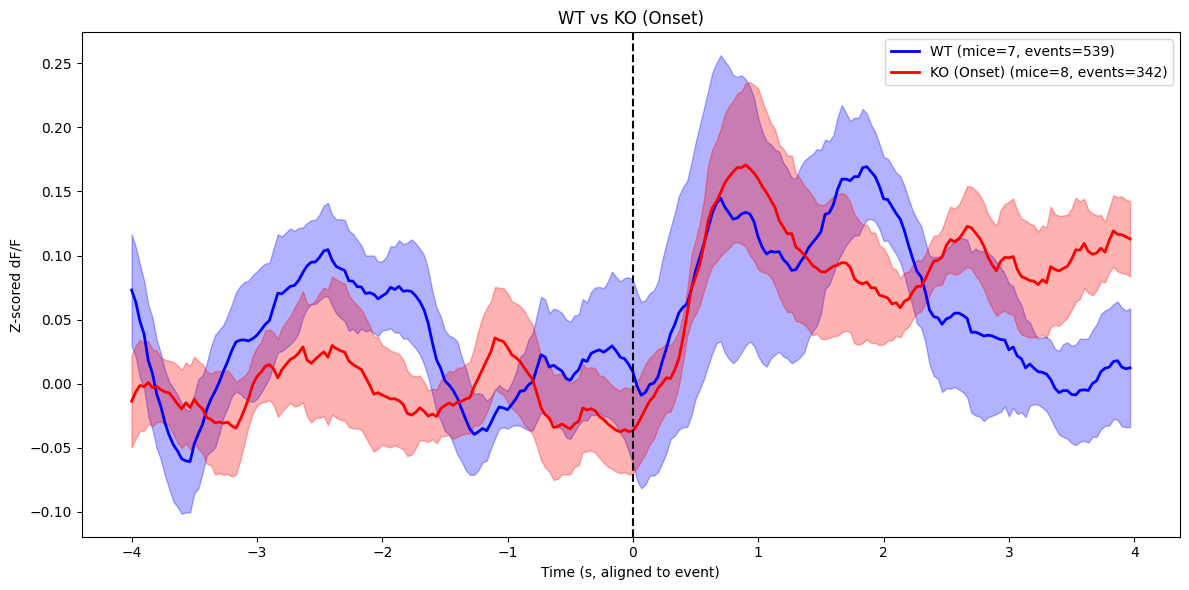


=== PRE/POST bars: WT vs KO (fdr_bh, alpha=0.05) ===
WT: n(pre)=7, n(post)=7
KO: n(pre)=8, n(post)=8
WT vs KO (PRE): p_raw=0.2157  p_corr=0.4314  -> not sig
WT vs KO (POST): p_raw=0.5638  p_corr=0.5638  -> not sig
WT (PRE vs POST, paired): p_raw=0.4169  p_corr=0.5559  -> not sig
KO (PRE vs POST, paired): p_raw=0.008624  p_corr=0.03449  -> SIGNIFICANT ✅


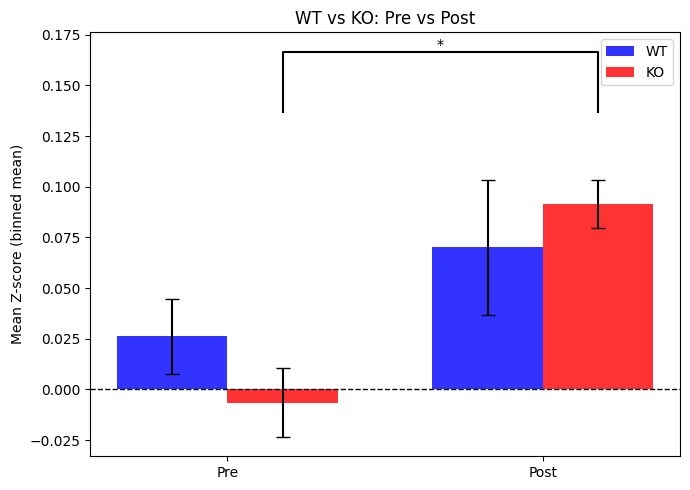


Statistical test results: WT vs KO (offset)
  Bin @ -3.85s : p=0.5521 -
  Bin @ -3.52s : p=0.1318 -
  Bin @ -3.18s : p=0.0824 -
  Bin @ -2.85s : p=0.0824 -
  Bin @ -2.52s : p=0.0824 -
  Bin @ -2.18s : p=0.3946 -
  Bin @ -1.85s : p=0.2535 -
  Bin @ -1.52s : p=0.2535 -
  Bin @ -1.18s : p=0.1088 -
  Bin @ -0.85s : p=0.1332 -
  Bin @ -0.52s : p=0.1734 -
  Bin @ -0.18s : p=0.5354 -
  Bin @ +0.15s : p=0.8770 -
  Bin @ +0.48s : p=0.9027 -
  Bin @ +0.82s : p=0.9027 -
  Bin @ +1.15s : p=0.1525 -
  Bin @ +1.48s : p=0.0824 -
  Bin @ +1.82s : p=0.0824 -
  Bin @ +2.15s : p=0.1525 -
  Bin @ +2.48s : p=0.2331 -
  Bin @ +2.82s : p=0.1525 -
  Bin @ +3.15s : p=0.0824 -
  Bin @ +3.48s : p=0.4440 -
  Bin @ +3.82s : p=0.4440 -


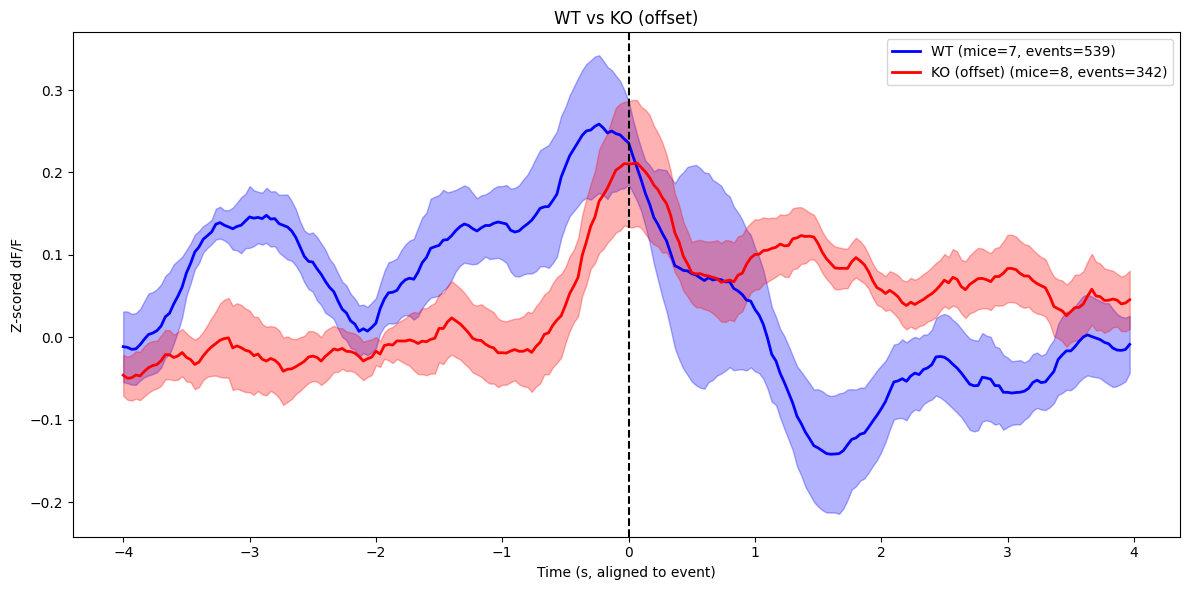


=== PRE/POST bars: WT vs KO (fdr_bh, alpha=0.05) ===
WT: n(pre)=7, n(post)=7
KO: n(pre)=8, n(post)=8
WT vs KO (PRE): p_raw=0.0003369  p_corr=0.001279  -> SIGNIFICANT ✅
WT vs KO (POST): p_raw=0.0006396  p_corr=0.001279  -> SIGNIFICANT ✅
WT (PRE vs POST, paired): p_raw=0.004541  p_corr=0.004541  -> SIGNIFICANT ✅
KO (PRE vs POST, paired): p_raw=0.003493  p_corr=0.004541  -> SIGNIFICANT ✅


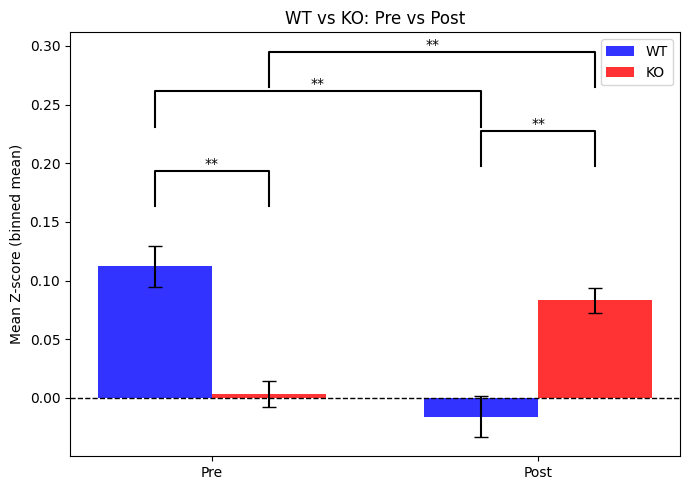


Statistical test results: Females vs Males (Onset)
  Bin @ -3.85s : p=0.8658 -
  Bin @ -3.52s : p=0.7738 -
  Bin @ -3.18s : p=0.3324 -
  Bin @ -2.85s : p=0.3324 -
  Bin @ -2.52s : p=0.7612 -
  Bin @ -2.18s : p=0.8360 -
  Bin @ -1.85s : p=0.6240 -
  Bin @ -1.52s : p=0.6203 -
  Bin @ -1.18s : p=0.7738 -
  Bin @ -0.85s : p=0.3957 -
  Bin @ -0.52s : p=0.3071 -
  Bin @ -0.18s : p=0.6240 -
  Bin @ +0.15s : p=0.6203 -
  Bin @ +0.48s : p=0.2472 -
  Bin @ +0.82s : p=0.3071 -
  Bin @ +1.15s : p=0.3650 -
  Bin @ +1.48s : p=0.7738 -
  Bin @ +1.82s : p=0.3957 -
  Bin @ +2.15s : p=0.3324 -
  Bin @ +2.48s : p=0.6240 -
  Bin @ +2.82s : p=0.6341 -
  Bin @ +3.15s : p=0.6936 -
  Bin @ +3.48s : p=0.6203 -
  Bin @ +3.82s : p=0.5754 -


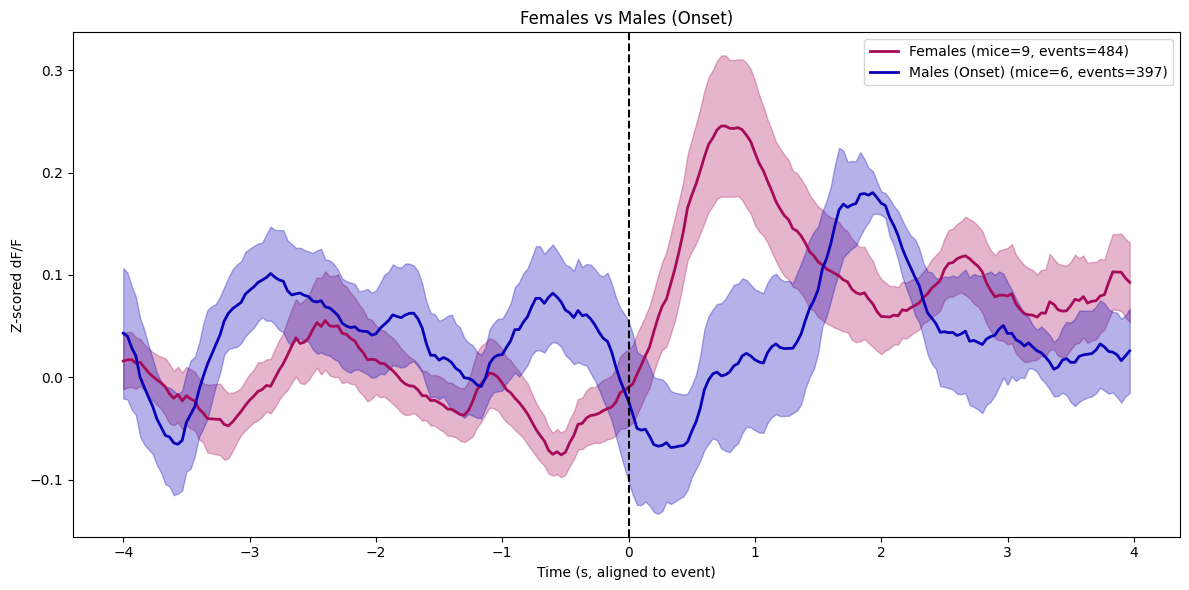


=== PRE/POST bars: Females vs Males (fdr_bh, alpha=0.05) ===
Females: n(pre)=9, n(post)=9
Males: n(pre)=6, n(post)=6
Females vs Males (PRE): p_raw=0.05196  p_corr=0.06928  -> not sig
Females vs Males (POST): p_raw=0.03475  p_corr=0.06928  -> not sig
Females (PRE vs POST, paired): p_raw=0.004823  p_corr=0.01929  -> SIGNIFICANT ✅
Males (PRE vs POST, paired): p_raw=0.9588  p_corr=0.9588  -> not sig


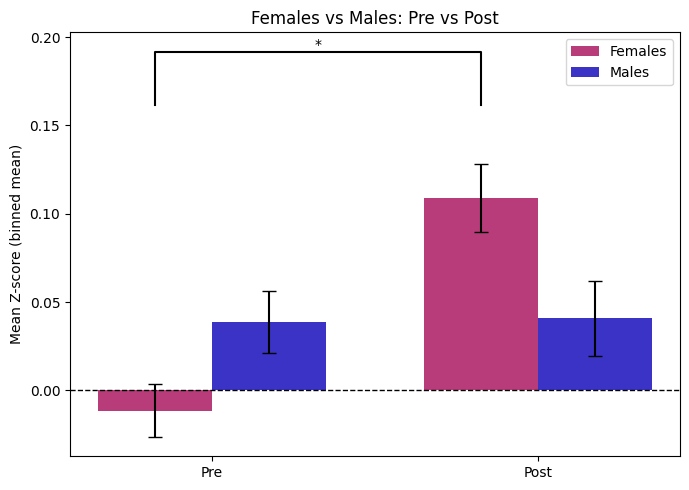


Statistical test results: Females vs Males (offset)
  Bin @ -3.85s : p=0.9193 -
  Bin @ -3.52s : p=0.9923 -
  Bin @ -3.18s : p=0.8013 -
  Bin @ -2.85s : p=0.8013 -
  Bin @ -2.52s : p=0.8013 -
  Bin @ -2.18s : p=0.9923 -
  Bin @ -1.85s : p=0.8013 -
  Bin @ -1.52s : p=0.7020 -
  Bin @ -1.18s : p=0.8013 -
  Bin @ -0.85s : p=0.9193 -
  Bin @ -0.52s : p=0.7078 -
  Bin @ -0.18s : p=0.4763 -
  Bin @ +0.15s : p=0.7078 -
  Bin @ +0.48s : p=0.8013 -
  Bin @ +0.82s : p=0.7078 -
  Bin @ +1.15s : p=0.8494 -
  Bin @ +1.48s : p=0.6123 -
  Bin @ +1.82s : p=0.4763 -
  Bin @ +2.15s : p=0.7078 -
  Bin @ +2.48s : p=0.8128 -
  Bin @ +2.82s : p=0.8667 -
  Bin @ +3.15s : p=0.9923 -
  Bin @ +3.48s : p=0.6123 -
  Bin @ +3.82s : p=0.7078 -


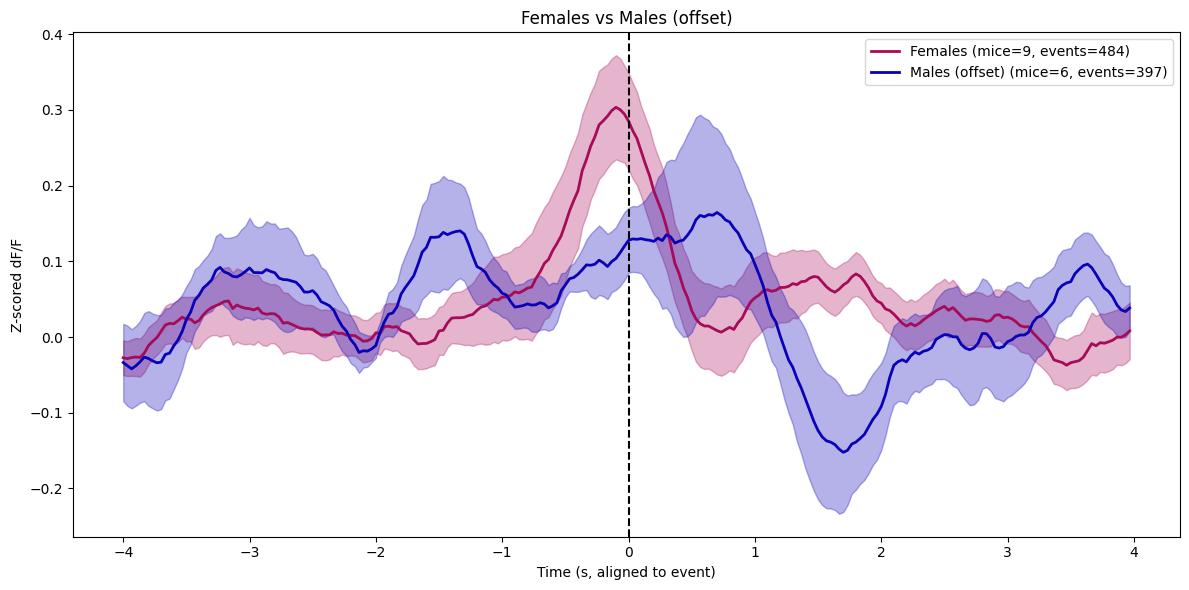


=== PRE/POST bars: Females vs Males (fdr_bh, alpha=0.05) ===
Females: n(pre)=9, n(post)=9
Males: n(pre)=6, n(post)=6
Females vs Males (PRE): p_raw=0.8943  p_corr=0.898  -> not sig
Females vs Males (POST): p_raw=0.5089  p_corr=0.898  -> not sig
Females (PRE vs POST, paired): p_raw=0.898  p_corr=0.898  -> not sig
Males (PRE vs POST, paired): p_raw=0.4491  p_corr=0.898  -> not sig


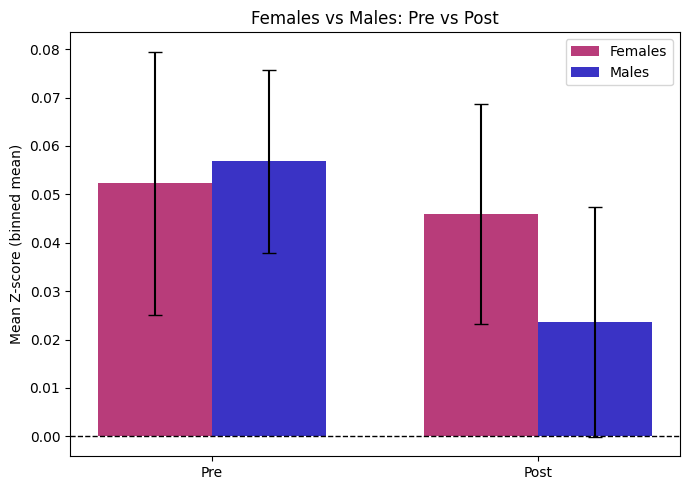

In [9]:
if __name__ == '__main__':
    # Load & group
    exps = load_experiments(data_folder)
    WT, KO = group_experiments_by_genotype(exps)
    Females, Males = group_experiments_by_sex(exps)

    # Common time grid
    common_t = build_common_time(PRE_TIME, POST_TIME, FRAME_RATE)

    # ----- Extract traces (onset & offset) -----
    raw_WT_on  = extract_hd_traces(WT,      PRE_TIME, POST_TIME, FRAME_RATE, "onset")
    raw_KO_on  = extract_hd_traces(KO,      PRE_TIME, POST_TIME, FRAME_RATE, "onset")
    raw_WT_off = extract_hd_traces(WT,      PRE_TIME, POST_TIME, FRAME_RATE, "offset")
    raw_KO_off = extract_hd_traces(KO,      PRE_TIME, POST_TIME, FRAME_RATE, "offset")

    raw_F_on   = extract_hd_traces(Females, PRE_TIME, POST_TIME, FRAME_RATE, "onset")
    raw_M_on   = extract_hd_traces(Males,   PRE_TIME, POST_TIME, FRAME_RATE, "onset")
    raw_F_off  = extract_hd_traces(Females, PRE_TIME, POST_TIME, FRAME_RATE, "offset")
    raw_M_off  = extract_hd_traces(Males,   PRE_TIME, POST_TIME, FRAME_RATE, "offset")

    # ----- Align to common grid -----
    aligned_WT_on  = align_hd_traces_to_common(raw_WT_on,  common_t)
    aligned_KO_on  = align_hd_traces_to_common(raw_KO_on,  common_t)
    aligned_WT_off = align_hd_traces_to_common(raw_WT_off, common_t)
    aligned_KO_off = align_hd_traces_to_common(raw_KO_off, common_t)

    aligned_F_on   = align_hd_traces_to_common(raw_F_on,   common_t)
    aligned_M_on   = align_hd_traces_to_common(raw_M_on,   common_t)
    aligned_F_off  = align_hd_traces_to_common(raw_F_off,  common_t)
    aligned_M_off  = align_hd_traces_to_common(raw_M_off,  common_t)

    # ----- Center each event by window mean (fraction) -----
    centered_WT_on  = center_traces_by_window(aligned_WT_on,  BASELINE_REDUCTION)
    centered_KO_on  = center_traces_by_window(aligned_KO_on,  BASELINE_REDUCTION)
    centered_WT_off = center_traces_by_window(aligned_WT_off, BASELINE_REDUCTION)
    centered_KO_off = center_traces_by_window(aligned_KO_off, BASELINE_REDUCTION)

    centered_F_on   = center_traces_by_window(aligned_F_on,   BASELINE_REDUCTION)
    centered_M_on   = center_traces_by_window(aligned_M_on,   BASELINE_REDUCTION)
    centered_F_off  = center_traces_by_window(aligned_F_off,  BASELINE_REDUCTION)
    centered_M_off  = center_traces_by_window(aligned_M_off,  BASELINE_REDUCTION)

    # ----- Per-mouse & group averages -----
    mouse_WT_on,  gavg_WT_on,  gsem_WT_on  = compute_hd_avg_traces(centered_WT_on)
    mouse_KO_on,  gavg_KO_on,  gsem_KO_on  = compute_hd_avg_traces(centered_KO_on)
    mouse_WT_off, gavg_WT_off, gsem_WT_off = compute_hd_avg_traces(centered_WT_off)
    mouse_KO_off, gavg_KO_off, gsem_KO_off = compute_hd_avg_traces(centered_KO_off)

    mouse_F_on,   gavg_F_on,   gsem_F_on   = compute_hd_avg_traces(centered_F_on)
    mouse_M_on,   gavg_M_on,   gsem_M_on   = compute_hd_avg_traces(centered_M_on)
    mouse_F_off,  gavg_F_off,  gsem_F_off  = compute_hd_avg_traces(centered_F_off)
    mouse_M_off,  gavg_M_off,  gsem_M_off  = compute_hd_avg_traces(centered_M_off)

    # =========================
    # WT vs KO PRE/POST bar plot + stats (ONSET)
    # =========================
    wt_pre, wt_post = compute_pre_post_values(centered_WT_on, common_t, PRE_TIME, POST_TIME, BIN_SIZE)
    ko_pre, ko_post = compute_pre_post_values(centered_KO_on, common_t, PRE_TIME, POST_TIME, BIN_SIZE)

    # Arrays for between-group comparisons (unpaired)
    wt_pre_vals  = np.array([v for v in wt_pre.values()  if np.isfinite(v)], dtype=float)
    wt_post_vals = np.array([v for v in wt_post.values() if np.isfinite(v)], dtype=float)
    ko_pre_vals  = np.array([v for v in ko_pre.values()  if np.isfinite(v)], dtype=float)
    ko_post_vals = np.array([v for v in ko_post.values() if np.isfinite(v)], dtype=float)

    print("\n=== WT vs KO PRE/POST (ONSET) ===")
    print(f"WT n (pre)={len(wt_pre_vals)}, WT n (post)={len(wt_post_vals)}")
    print(f"KO n (pre)={len(ko_pre_vals)}, KO n (post)={len(ko_post_vals)}")

    # Between-group stats (WT vs KO) for pre and post
    _, p_pre  = ttest_ind(wt_pre_vals,  ko_pre_vals,  equal_var=False)
    _, p_post = ttest_ind(wt_post_vals, ko_post_vals, equal_var=False)

    # Within-group stats (paired pre vs post within the same mouse)
    wt_common = sorted(set(wt_pre.keys()) & set(wt_post.keys()))
    ko_common = sorted(set(ko_pre.keys()) & set(ko_post.keys()))

    wt_pre_paired  = np.array([wt_pre[m]  for m in wt_common if np.isfinite(wt_pre[m]) and np.isfinite(wt_post[m])], dtype=float)
    wt_post_paired = np.array([wt_post[m] for m in wt_common if np.isfinite(wt_pre[m]) and np.isfinite(wt_post[m])], dtype=float)

    ko_pre_paired  = np.array([ko_pre[m]  for m in ko_common if np.isfinite(ko_pre[m]) and np.isfinite(ko_post[m])], dtype=float)
    ko_post_paired = np.array([ko_post[m] for m in ko_common if np.isfinite(ko_pre[m]) and np.isfinite(ko_post[m])], dtype=float)

    p_wt = np.nan
    p_ko = np.nan
    if len(wt_pre_paired) >= 2:
        _, p_wt = ttest_rel(wt_pre_paired, wt_post_paired)
    if len(ko_pre_paired) >= 2:
        _, p_ko = ttest_rel(ko_pre_paired, ko_post_paired)

    print(f"WT vs KO (PRE):  p = {p_pre:.4g}")
    print(f"WT vs KO (POST): p = {p_post:.4g}")
    print(f"WT PRE vs POST (paired): p = {p_wt:.4g}  (n={len(wt_pre_paired)})")
    print(f"KO PRE vs POST (paired): p = {p_ko:.4g}  (n={len(ko_pre_paired)})")

    # Bar plot values (means + SEM)
    wt_pre_m,  wt_pre_se  = mean_sem(wt_pre_vals)
    wt_post_m, wt_post_se = mean_sem(wt_post_vals)
    ko_pre_m,  ko_pre_se  = mean_sem(ko_pre_vals)
    ko_post_m, ko_post_se = mean_sem(ko_post_vals)

    labels = ["Pre", "Post"]
    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(7, 5))

    # WT bars
    ax.bar(x - width/2, [wt_pre_m, wt_post_m], width,
           yerr=[wt_pre_se, wt_post_se], capsize=5, label="WT", color="blue", alpha=0.8)

    # KO bars
    ax.bar(x + width/2, [ko_pre_m, ko_post_m], width,
           yerr=[ko_pre_se, ko_post_se], capsize=5, label="KO", color="red", alpha=0.8)

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Mean Z-score (binned mean)")
    ax.set_title("WT vs KO: Pre vs Post Head-Dip (Onset)")
    ax.legend()
    ax.axhline(0, linestyle="--", linewidth=1, color="k")

    plt.tight_layout()
    plt.show()

    # ----- Separate per-group plots (Genotype) -----
    plot_traces(common_t, mouse_WT_on,  gavg_WT_on,  gsem_WT_on,
                title=f"WT Onset (mice={len(mouse_WT_on)}, events={count_group_events(centered_WT_on)})",
                color="blue")
    plot_traces(common_t, mouse_KO_on,  gavg_KO_on,  gsem_KO_on,
                title=f"KO Onset (mice={len(mouse_KO_on)}, events={count_group_events(centered_KO_on)})",
                color="red")
    plot_traces(common_t, mouse_WT_off, gavg_WT_off, gsem_WT_off,
                title=f"WT Offset (mice={len(mouse_WT_off)}, events={count_group_events(centered_WT_off)})",
                color="blue")
    plot_traces(common_t, mouse_KO_off, gavg_KO_off, gsem_KO_off,
                title=f"KO Offset (mice={len(mouse_KO_off)}, events={count_group_events(centered_KO_off)})",
                color="red")

    # ----- Separate per-group plots (Sex) -----
    plot_traces(common_t, mouse_F_on,   gavg_F_on,   gsem_F_on,
                title=f"Females Onset (mice={len(mouse_F_on)}, events={count_group_events(centered_F_on)})",
                color="#A60B59")
    plot_traces(common_t, mouse_M_on,   gavg_M_on,   gsem_M_on,
                title=f"Males Onset (mice={len(mouse_M_on)}, events={count_group_events(centered_M_on)})",
                color="#0900B7")
    plot_traces(common_t, mouse_F_off,  gavg_F_off,  gsem_F_off,
                title=f"Females Offset (mice={len(mouse_F_off)}, events={count_group_events(centered_F_off)})",
                color="#A60B59")
    plot_traces(common_t, mouse_M_off,  gavg_M_off,  gsem_M_off,
                title=f"Males Offset (mice={len(mouse_M_off)}, events={count_group_events(centered_M_off)})",
                color="#0900B7")

    # ----- Combined plots with stats (Genotype) -----
    plot_combined_groups_with_stats(
        common_t,
        centered_WT_on,  gavg_WT_on,  gsem_WT_on,  "WT", "blue",
        centered_KO_on,  gavg_KO_on,  gsem_KO_on,  "KO (Onset)", "red",
        n_mice_A=len(mouse_WT_on),  n_events_A=count_group_events(centered_WT_on),
        n_mice_B=len(mouse_KO_on),  n_events_B=count_group_events(centered_KO_on),
        bin_size=BIN_SIZE, alpha=ALPHA
    )
    plot_pre_post_bars_for_two_groups(
        common_t,
        centered_WT_on, "WT", "blue",
        centered_KO_on, "KO", "red",
        pre_time=PRE_TIME, post_time=POST_TIME, bin_size=BIN_SIZE
    )

    plot_combined_groups_with_stats(
        common_t,
        centered_WT_off, gavg_WT_off, gsem_WT_off, "WT", "blue",
        centered_KO_off, gavg_KO_off, gsem_KO_off, "KO (offset)", "red",
        n_mice_A=len(mouse_WT_off), n_events_A=count_group_events(centered_WT_off),
        n_mice_B=len(mouse_KO_off), n_events_B=count_group_events(centered_KO_off),
        bin_size=BIN_SIZE, alpha=ALPHA
    )

    plot_pre_post_bars_for_two_groups(
        common_t,
        centered_WT_off, "WT", "blue",
        centered_KO_off, "KO", "red",
        pre_time=PRE_TIME, post_time=POST_TIME, bin_size=BIN_SIZE
    )

    # ----- Combined plots with stats (Sex) -----
    plot_combined_groups_with_stats(
        common_t,
        centered_F_on,  gavg_F_on,  gsem_F_on,  "Females", "#A60B59",
        centered_M_on,  gavg_M_on,  gsem_M_on,  "Males (Onset)",   "#0900B7",
        n_mice_A=len(mouse_F_on),  n_events_A=count_group_events(centered_F_on),
        n_mice_B=len(mouse_M_on),  n_events_B=count_group_events(centered_M_on),
        bin_size=BIN_SIZE, alpha=ALPHA
    )
    plot_pre_post_bars_for_two_groups(
        common_t,
        centered_F_on, "Females", "#A60B59",
        centered_M_on, "Males",   "#0900B7",
        pre_time=PRE_TIME, post_time=POST_TIME, bin_size=BIN_SIZE
    )

    plot_combined_groups_with_stats(
        common_t,
        centered_F_off, gavg_F_off, gsem_F_off, "Females", "#A60B59",
        centered_M_off, gavg_M_off, gsem_M_off, "Males (offset)",   "#0900B7",
        n_mice_A=len(mouse_F_off), n_events_A=count_group_events(centered_F_off),
        n_mice_B=len(mouse_M_off), n_events_B=count_group_events(centered_M_off),
        bin_size=BIN_SIZE, alpha=ALPHA
    )
    plot_pre_post_bars_for_two_groups(
        common_t,
        centered_F_off, "Females", "#A60B59",
        centered_M_off, "Males",   "#0900B7",
        pre_time=PRE_TIME, post_time=POST_TIME, bin_size=BIN_SIZE
    )